## 1. Catchments


In [1]:
# 1. calculate catchment areasa in Qgis usuing Qswat model for catchment deliniation, 
#    build a table with catchment information and morphometrical (catchments + streams + glaciers) 

#   - take dem from jaxa (aw3d30m)
#   - reproject to UTM (utm will allow the areas)
#   - calcualte streams (same area threshold as for channels)
#   - calculate catchments/watersheds (5km2 area)
#   - zonal statistics bacse on elevetion 
#   - zonal statistics based on slope 
#   - merge streams info (length etc) with catchments atributes (LinkNO = PolygonID) 
#   - cantroid coordinates (UTM) 
#   - centroin coordinates (WGS) 
#   - glaciers of nepal (from Jakob): 
#      - join (to "cut" glacier polygon by cathcments) 
#      - calculate areas ofa this new polygons (-> the % of the glacier in the catchment) 



#  ----------------------------------
#  issues here: 
#    the way catchments are calculated? 
#    what parameters do we need (same as others + everything we can think of) 

# way to solve/ideas: 
#   maybe instead of taking square tiles of DEM take specific valeys,
#   that makes more physical/common sence (pysheds library?) 
    
# (anything else?)



#  ----------------------------------
#  what happens after: 
#   - take only columns that you want ( TODO: inset list of columns you want) 
#   - plot relationship of that data 


#  ----------------------------------
''' update: 
    ...joined.shp files for catchments (after the joint operation in qgis 
                  -> add glacier attributes into it (one-to-one join) 
       + maybe needs foltering some super small polygons that are identified as catchments by qswat (filter by area) 
    ..centroids.shp files for centroids (split column with coordinates) 
    . 
'''


' update: \n    ...joined.shp files for catchments (after the joint operation in qgis \n                  -> add glacier attributes into it (one-to-one join) \n       + maybe needs foltering some super small polygons that are identified as catchments by qswat (filter by area) \n    ..centroids.shp files for centroids (split column with coordinates) \n    . \n'

## 2. Climate data

In [2]:
# 2. Take climate data and centroid coordinates of the catchments and fetch the data using coordinates,
#    then append to the table 
#    explore the data 

#  issues here: scale! climate data needs to be downscaled somehow


In [3]:
import xarray as xr
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [4]:
#  names of variables: 

#  df                      - original cathcments table 
#  catchments              - df with only 'chosen' columns 
#  catchments              - df with only 'chosen' columns with new names (!!!)
#  catchments_glacier      - only glacier parameters
#  catchments_cath_streams - river and catchment parameters 

#  f - original netcdf
 

### get all catchment data to a pd dataframe

In [5]:
# read table 
# df = pd.read_csv('glaciers_catchments_streams_intersection.csv')
# plot shp. with cathments on top of era5 data: 

# catchment polygons
catch_polygons = gpd.read_file('catchments/likely_correct/catchments_glaciers_joined_one2one.shp')
# centroid points
catch_points   = gpd.read_file('catchments/likely_correct/catchments_centroids.shp')
# intersected glaciers 
catch_glaciers = gpd.read_file('catchments/likely_correct/glaciers_intersect_catchments.shp')

In [6]:
# glaciers groupby 
catch_glaciers = catch_glaciers[['PolygonId', 'gl_area_km']]
catch_glaciers['gl_area_m2'] = catch_glaciers.gl_area_km*(10**6)
catch_glaciers_groupby = catch_glaciers.groupby('PolygonId').sum()

# catchment centroid points add to polygons: 
catch_points = catch_points[['PolygonId', 'x_centr', 'y_centr']]


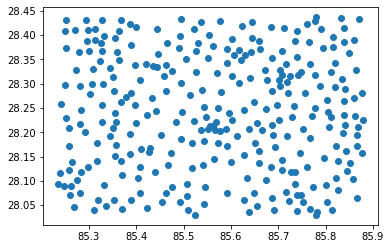

In [7]:
plt.scatter(catch_points.x_centr, catch_points.y_centr)

In [8]:
# add stuff to cathment polygons

''' merge tables: take 'smaller' table and add the 'bigger' table to it 
# (otherwise there will be a lot of nan vallues, .dropna - if there are any)'''
# combined_table = catchments.merge(mean_points_df, on=['x_wgs', 'y_wgs'], how='left')

df = catch_polygons.merge(catch_points, on = ['PolygonId'], how = 'left')
df = df.merge(catch_glaciers_groupby, on = ['PolygonId'], how = 'left')

In [9]:
# to dataframe 

df = pd.DataFrame(df) 
# df.columns

In [10]:
# what columns are you interested in?

## ----- glacier parameters: 

# "Elv_min": "elv_min_glacier"
# "Elv_mean": "elv_mean_glacier"
# "Elv_max": "elv_max_glacier"
# "Slope_min": "min_slope_glacier"
# "Slope_mean": "mean_slope_glacier"
# "Slope_max": "max_slope_glacier"
# "Aspect": "aspect_glacier"
# "Area_SqKm": "area_glacier_km2"
# "Thickness": "thickness"

## ---- catchments: 

# PolygonId: "PolygonId"
# Area : "catchment_area"
# X : "x_utm"
# Y : "y_utm"
# x_wgs : "x_wgs"
# y_wgs : "y_wgs"
# _mean_elev : "mean_elevation"
# _median_el " "mean_elevation"
# _stdev_ele: "std_elevation"
# _min_elev: "min_elevation"
# _max_elev: "max_elevation"
# _range_ele: "range_elevation"
# _mean_slop: "mean_slope"
# _median_sl: "median_slope"
# _stdev_slo: "std_slope"
# _min_slope: "min_slope"
# _max_slope : "max_slope"
# _range_slo : "range_slope"
# _varianc_1 : "variance_slope"
# area_glac_ : "area_of_glacier"


## ----- streams: 

# strmOrder: "stream_order"
# Length: "stream_length"
# strmDrop: "stream_drop"
# Slope: "stream_slope" 
# StraightL: "stream_streightL"

# df.rename(columns={"A": "a", "B": "c"})

In [11]:
# len(df)
df.columns

Index(['PolygonId', 'Area', 'Subbasin', 'X', 'Y', '_mean_elev', '_median_el',
       '_stdev_ele', '_min_elev', '_max_elev', '_range_ele', '_variance_',
       'LINKNO', 'DSLINKNO', 'USLINKNO1', 'USLINKNO2', 'DSNODEID', 'strmOrder',
       'Length', 'Magnitude', 'DSContArea', 'strmDrop', 'Slope', 'StraightL',
       'USContArea', 'WSNO', 'DOUTEND', 'DOUTSTART', 'DOUTMID', 'BasinNo',
       '_mean_slop', '_median_sl', '_stdev_slo', '_min_slope', '_max_slope',
       '_range_slo', '_varianc_1', 'ID', 'GLIMS_ID', 'Basin', 'Sub_Basin',
       'Images', 'Longitude', 'Latitude', 'Class', 'Elv_min', 'Elv_mean',
       'Elv_max', 'Slope_min', 'Slope_mean', 'Slope_max', 'Aspect',
       'Area_SqKm', 'Thickness', 'Reserve', 'Year', 'Shape_area', 'Shape_len',
       'x_centroid', 'y_centroid', '_count', '_sum', '_mean', '_median',
       '_stdev', '_min', '_max', '_range', '_minority', '_majority',
       '_variety', '_variance', 'geometry', 'x_centr', 'y_centr', 'gl_area_km',
       'gl_area_m2'

In [12]:
# take the columns you want, rename (to avoid confusuon, but be very carefull here!) 

catchments = df[['PolygonId', 'Area', 'X', 'Y', '_mean_elev', '_median_el', '_stdev_ele', 
                 '_min_elev', '_max_elev',
                 '_range_ele', '_variance_', 'strmOrder', 'Length', 'strmDrop', 'Slope', '_varianc_1'  ,
                 '_mean_slop', '_median_sl', '_stdev_slo', '_min_slope', '_max_slope', '_range_slo', 
                 'x_centr', 'y_centr', 'StraightL', 
                 'gl_area_m2', 
                 # 'gl_area_km'
                ]]

In [13]:
# check if its all correct
# catchments.head()
catchments.columns

Index(['PolygonId', 'Area', 'X', 'Y', '_mean_elev', '_median_el', '_stdev_ele',
       '_min_elev', '_max_elev', '_range_ele', '_variance_', 'strmOrder',
       'Length', 'strmDrop', 'Slope', '_varianc_1', '_mean_slop', '_median_sl',
       '_stdev_slo', '_min_slope', '_max_slope', '_range_slo', 'x_centr',
       'y_centr', 'StraightL', 'gl_area_m2'],
      dtype='object')

In [14]:
# raname columns so that it makes sense: 


catchments = catchments.rename(columns={
                'PolygonId': 'PolygonId', 
                 'Area': 'catchment_area_m2', 
                 'X': 'x_utm', 
                 'Y': 'y_utm', 
                 '_mean_elev': 'mean_elevation',
                 '_median_el': 'median_elevation',
                 '_stdev_ele': 'std_elevation', 
                 '_min_elev': 'min_elevation', 
                 '_max_elev': 'max_elevation',
                 '_range_ele': 'range_elevation', 
                 '_variance_': 'variance_elevation', 
                 'strmOrder': 'stream_order', 
                 'Length': 'stream_length', 
                 'strmDrop': 'stream_drop', 
                 'Slope': 'stream_slope', 
                 '_mean_slop': 'mean_slope', 
                 '_median_sl': 'median_slope', 
                 '_stdev_slo': 'std_slope', 
                 '_min_slope': 'min_elevation', 
                 '_max_slope': 'max_slope', 
                 '_range_slo': 'range_slope', 
                 '_varianc_1' : 'variance_slope',
                 'x_centr': 'x_wgs', 
                 'y_centr': 'y_wgs', 
                 'StraightL': 'StraightL', 
                 'gl_area_m2': 'area_glacier_m2', 
                 # 'gl_area_km': 'area_glacier_km2'
})

In [15]:
catchments['glacier_percent'] = (catchments.catchment_area_m2 / catchments.area_glacier_m2)*100
# catchments.glacier_percent.replace(0, np.nan, inplace = True)

In [16]:
# catchments


In [17]:
print('max % of the glacier in the catchment: ', catchments.glacier_percent.max())

max % of the glacier in the catchment:  50.298


## Correlations

In [18]:
catchments_corr = catchments.corr()

Text(0.5, 1.0, 'various parameters')

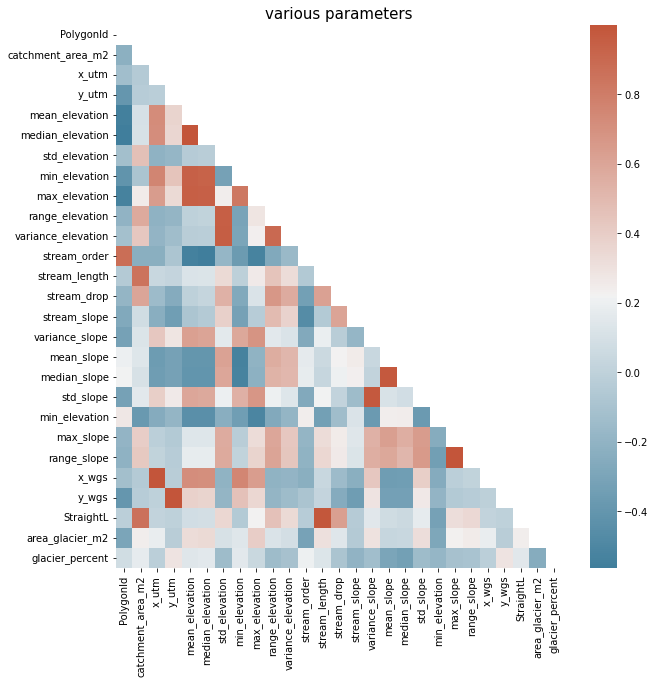

In [19]:
# catchments and streams 

plt.figure(figsize=(10, 10))

# mask for the upper triangle
mask = np.triu(np.ones_like(catchments_corr, dtype=bool))
# color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# heatmap 
sns.heatmap(catchments_corr, cmap=cmap, mask = mask)
# sns.heatmap(catchments_corr, cmap=cmap)
plt.title('various parameters', fontsize = 15)

# plt.savefig('various_params_corr.png', dpi = 300, bbox_inches='tight')

## Scatterplots (todo: many scatterplots with many parameters) 

<AxesSubplot:xlabel='stream_length', ylabel='median_elevation'>

<Figure size 576x432 with 0 Axes>

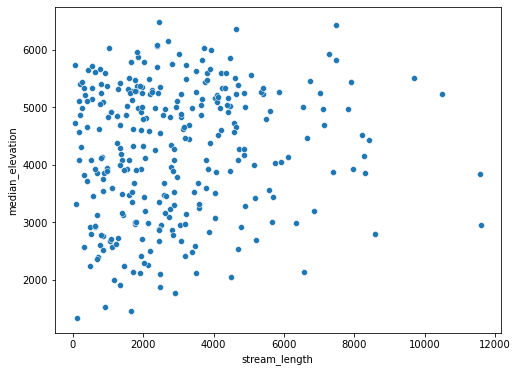

In [20]:
plt.figure(figsize=(8, 6))
# sns.scatterplot(data = catchments, x = "catchment_area_m2", y = "stream_length")


plt.figure(figsize=(8, 6))
sns.scatterplot(data = catchments, x = "stream_length", y = "median_elevation")

# Climate era5 data:

In [21]:
# f  - original era5
# df - original era5 as dataframe

In [22]:
# open dataset
f = xr.open_dataset('era5_monthly_averaged_reanalysis_1979_present.nc')

''' whats in there: 
# 2m temperature, Forecast albedo, Snow depth, Surface latent heat flux, Total precipitation

# 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 
2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 
# January, February, March, April, May, June, July, August, September, October, November, December (monthly)

'''

' whats in there: \n# 2m temperature, Forecast albedo, Snow depth, Surface latent heat flux, Total precipitation\n\n# 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, \n2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 \n# January, February, March, April, May, June, July, August, September, October, November, December (monthly)\n\n'

In [23]:
# f
# f['tp']
# print(f)

In [24]:
# extract arrays from .nc file:

lons = f.longitude 
lats = f.latitude
time = f.time

t2m  = f.t2m   # 2m temp in K
fal  = f.fal   # forecasted albedo 
sd   = f.sd    # snow depth
slhf = f.slhf  # surface latent heat flux
tp   = f.tp    # total precip

print(tp.shape) # shape: time, lat lon 

(384, 9, 13)


In [25]:
## convert netCDF to pandas data frame 
# convert to dataframe:
# df = f.reset_coords(drop=True).to_dataframe()
# df

In [26]:
# time.values
# time
f.dims # dimentions

Frozen({'longitude': 13, 'latitude': 9, 'time': 384})

## plot era5 data 

shape of the data: (384, 9, 13)


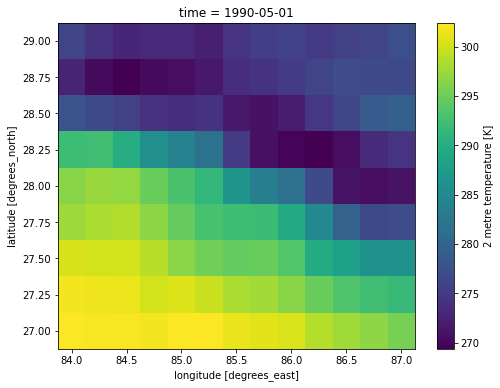

In [27]:
# plot an example 
print('shape of the data:', t2m.shape)

plt.figure(figsize=(8, 6))
t2m[4,:,:].plot() # t2m[0,:,:] - 0 time step 


### plot catchments on top of era5 data

In [28]:
# plot shp. with cathments on top of era5 data: 


In [29]:
# len(catch_polygons)
# len(catchments)
# catchments
catch_polygons.head()

,PolygonId,Area,Subbasin,X,Y,_mean_elev,_median_el,_stdev_ele,_min_elev,_max_elev,...,_median,_stdev,_min,_max,_range,_minority,_majority,_variety,_variance,geometry
0,35,2082.39,None,328760,3139854,4262.080782,4279.0,567.428865,3028.0,5633.0,...,4280.0,568.392970,3028.0,5630.0,2602.0,3028.0,4386.0,2521,323070.568314,"POLYGON ((85.26332 28.35510, 85.26333 28.35484..."
1,45,2025.14,None,330719,3134755,4182.969949,4178.0,576.714259,2733.0,5635.0,...,4179.0,576.573312,2733.0,5635.0,2902.0,2733.0,4290.0,2701,332436.784113,"POLYGON ((85.27338 28.30514, 85.27136 28.30511..."
2,223,2660.66,None,360687,3129518,5035.085857,4975.0,583.998144,3952.0,6620.0,...,4977.0,583.656671,3952.0,6620.0,2668.0,3958.0,4475.0,2539,340655.109123,"POLYGON ((85.61642 28.26023, 85.61584 28.26023..."
3,63,1239.68,None,364435,3131397,5389.377854,5344.0,352.609830,4569.0,6315.0,...,5343.0,352.459732,4569.0,6315.0,1746.0,4569.0,5217.0,1655,124227.862933,"POLYGON ((85.62013 28.28608, 85.61984 28.28608..."
4,81,1274.48,None,347053,3125258,4625.695439,4725.0,715.079257,2679.0,6482.0,...,4726.0,715.406067,2679.0,6482.0,3803.0,2679.0,4626.0,3241,511805.840254,"POLYGON ((85.44523 28.22210, 85.44524 28.22185..."


<AxesSubplot:>

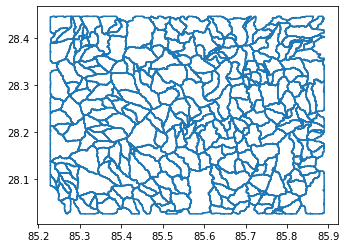

In [30]:
catch_polygons.boundary.plot()

<AxesSubplot:title={'center':'time = 2002-11-01'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

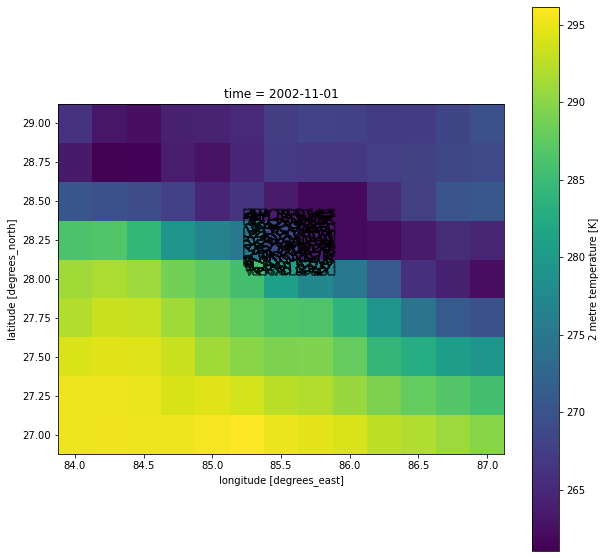

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
t2m[154,:,:].plot(ax=ax) 
catch_polygons.boundary.plot(ax=ax, alpha=.6, color='black')
# plt.title('')

# tutorial for this:
# https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

# plt.savefig('era5_catchments.png', dpi = 300, bbox_inches='tight')

### Multiple in one fig

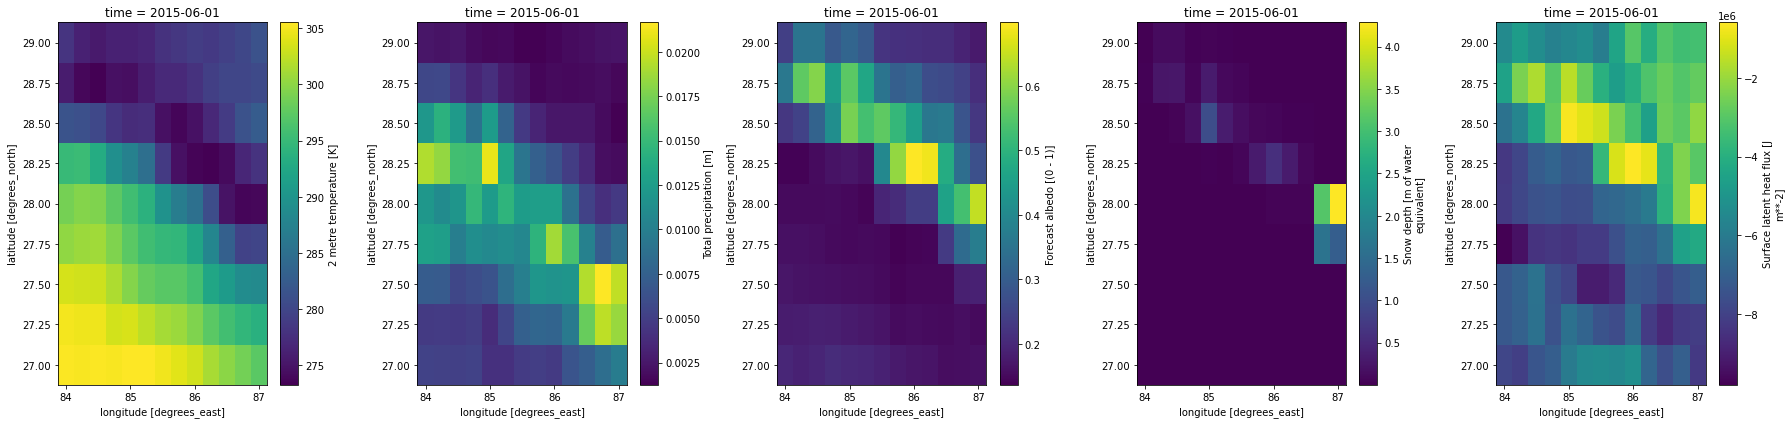

In [32]:
# plot multiple: 

fig, axes = plt.subplots(1, 5, figsize = (25,6))
t2m [305,:,:].plot(ax=axes[0])
tp  [305,:,:].plot(ax=axes[1])
fal [305,:,:].plot(ax=axes[2])
sd  [305,:,:].plot(ax=axes[3])
slhf[305,:,:].plot(ax=axes[4])

plt.tight_layout()

In [33]:
# f['tp'].plot()


## Calculate mean values

#### 1. just mean values over the entire time 

In [34]:
# mean vallues + keep the coordinates
fmeans = f.mean(dim='time', keep_attrs = True) 
# fmeans 

In [35]:
# extract arrays from .nc file:

lons_mean = fmeans.longitude 
lats_mean = fmeans.latitude
# time_mean = fmeans.time  # - no - since no time attribute anymore

t2m_mean  = fmeans.t2m  # 2m temp in K
fal_mean  = fmeans.fal  # forecasted albedo 
sd_mean   = fmeans.sd   # snow depth
slhf_mean = fmeans.slhf # surface latent heat flux
tp_mean   = fmeans.tp   # total precip

tp_mean.shape

(9, 13)

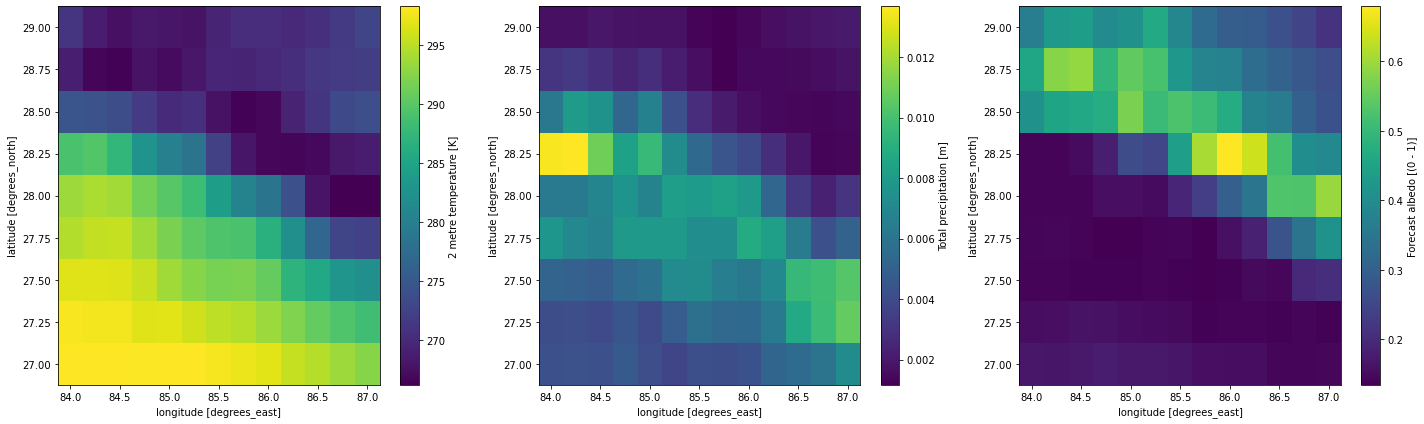

In [36]:
# plot multiple: 

# fig, axes = plt.subplots(1, 5, figsize = (25,6))
fig, axes = plt.subplots(1, 3, figsize = (20,6))
# plt.title('mean vallues 1990-2021')

t2m_mean [:,:].plot(ax=axes[0])  # 
tp_mean  [:,:].plot(ax=axes[1])  # 
fal_mean [:,:].plot(ax=axes[2])  # 
# sd_mean  [:,:].plot(ax=axes[3])  # 
# slhf_mean[:,:].plot(ax=axes[4])  # only 2 indexes needed for coordinates

# fig.suptitle('title', fontsize=16, y=1.02)
plt.tight_layout()

In [37]:
# catchments.x_wgs
fmeans

<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 9)
Coordinates:
  * longitude  (longitude) float32 84.0 84.25 84.5 84.75 ... 86.5 86.75 87.0
  * latitude   (latitude) float32 29.0 28.75 28.5 28.25 ... 27.5 27.25 27.0
Data variables:
    t2m        (latitude, longitude) float32 271.2 268.7 267.5 ... 293.6 292.4
    fal        (latitude, longitude) float32 0.3633 0.4273 ... 0.1421 0.1446
    sd         (latitude, longitude) float32 0.02584 0.04403 ... 7.575e-07
    slhf       (latitude, longitude) float32 -2.394e+06 ... -6.342e+06
    tp         (latitude, longitude) float32 0.001671 0.001676 ... 0.007178
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 15:24:18 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

### append means to the "cathments" table 

In [38]:
# 1. get coordinates:
'''(NB: be carefil with x and y) 
x - 85, y - 28
longitude - 85, latitude - 28 ''' 

catchments = catchments.sort_values(by=['x_wgs', 'y_wgs'])

lats = catchments.y_wgs
lons = catchments.x_wgs

mean_points = fmeans.sel(longitude=lons, latitude=lats, method='nearest')

# 1.1. add old coordinates - ovewrite dimentions 
mean_points['longitude'] = lons.values
mean_points['latitude']= lats.values


In [39]:
mean_points

<xarray.Dataset>
Dimensions:    (longitude: 297, latitude: 297)
Coordinates:
  * longitude  (longitude) float64 85.23 85.24 85.24 85.25 ... 85.88 85.88 85.88
  * latitude   (latitude) float64 28.09 28.12 28.26 28.09 ... 28.16 28.28 28.23
Data variables:
    t2m        (latitude, longitude) float32 288.2 288.2 288.2 ... 266.8 266.8
    fal        (latitude, longitude) float32 0.1498 0.1498 ... 0.6787 0.6787
    sd         (latitude, longitude) float32 0.006172 0.006172 ... 0.158 0.158
    slhf       (latitude, longitude) float32 -5.468e+06 ... -1.185e+06
    tp         (latitude, longitude) float32 0.008119 0.008119 ... 0.003941
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 15:24:18 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [40]:
# mean_points plot

In [41]:
# 2. convert to data frame 
# mean_points_df = mean_points.reset_coords(drop=True).to_dataframe()
mean_points_df = mean_points.to_dataframe() # dimentions: number of catchments squared

# check: coordinates should be: (lon: 85,25 - 86, lat: 28.0 - 28.5) 
#        old coordinates should be there! 


In [42]:
# new table looks like this 
# mean_points_df.head()
len(mean_points_df) # should = 297*297

# 297*297

88209

In [43]:
# reset index - make
# latitude and longitude new columns 
mean_points_df = mean_points_df.reset_index()

In [44]:
mean_points_df.head()
# catchments.x_wgs # = longitude

,longitude,latitude,t2m,fal,sd,slhf,tp
0,85.235,28.093,288.242310,0.149817,0.006172,-5468113.0,0.008119
1,85.235,28.116,288.242310,0.149817,0.006172,-5468113.0,0.008119
2,85.235,28.259,278.428558,0.248992,0.033110,-4377374.5,0.007180
3,85.235,28.089,288.242310,0.149817,0.006172,-5468113.0,0.008119
4,85.235,28.298,278.428558,0.248992,0.033110,-4377374.5,0.007180


In [45]:
# make new dataframe more appealing (!!! be carefull with x and y !!!) 

# reset index - make latitude and longitude new columns 
# mean_points_df= mean_points_df.reset_index()
mean_points_df_renamed = mean_points_df.rename(columns = {'longitude': 'x_wgs', 'latitude': 'y_wgs'}) 


In [46]:
# catchments.x_wgs
mean_points_df_renamed.head()

,x_wgs,y_wgs,t2m,fal,sd,slhf,tp
0,85.235,28.093,288.242310,0.149817,0.006172,-5468113.0,0.008119
1,85.235,28.116,288.242310,0.149817,0.006172,-5468113.0,0.008119
2,85.235,28.259,278.428558,0.248992,0.033110,-4377374.5,0.007180
3,85.235,28.089,288.242310,0.149817,0.006172,-5468113.0,0.008119
4,85.235,28.298,278.428558,0.248992,0.033110,-4377374.5,0.007180


In [47]:
# new table looks like this
# catchments
# catchments

In [48]:
#  merge tables: take 'smaller' table and add the 'bigger' table to it 
# (otherwise there will be a lot of nan vallues, .dropna - if there are any)

catchments_climate = catchments.merge(mean_points_df_renamed, on=['x_wgs', 'y_wgs'], how='left').drop_duplicates()


In [49]:
len(catchments_climate)

297

### plot correlations with climatic variables

In [50]:
catchments_climate.columns

Index(['PolygonId', 'catchment_area_m2', 'x_utm', 'y_utm', 'mean_elevation',
       'median_elevation', 'std_elevation', 'min_elevation', 'max_elevation',
       'range_elevation', 'variance_elevation', 'stream_order',
       'stream_length', 'stream_drop', 'stream_slope', 'variance_slope',
       'mean_slope', 'median_slope', 'std_slope', 'min_elevation', 'max_slope',
       'range_slope', 'x_wgs', 'y_wgs', 'StraightL', 'area_glacier_m2',
       'glacier_percent', 't2m', 'fal', 'sd', 'slhf', 'tp'],
      dtype='object')

In [51]:
# 1. correlations:
catchments_climate_corr = catchments_climate.corr()


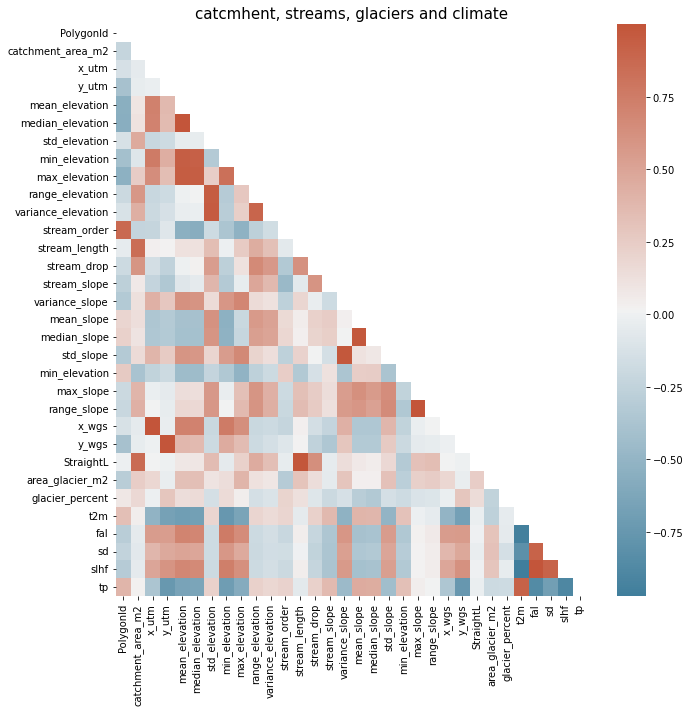

In [52]:
# catchments and streams 

plt.figure(figsize=(10, 10))

# mask for the upper triangle
mask = np.triu(np.ones_like(catchments_climate_corr, dtype=bool))
# color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# heatmap 
sns.heatmap(catchments_climate_corr, cmap=cmap, mask = mask)
plt.title('catcmhent, streams, glaciers and climate', fontsize = 15)
plt.tight_layout()

# plt.savefig('catch_climate_corr.png', dpi = 300, bbox_inches = 'tight')

In [53]:
catchments_climate.columns

Index(['PolygonId', 'catchment_area_m2', 'x_utm', 'y_utm', 'mean_elevation',
       'median_elevation', 'std_elevation', 'min_elevation', 'max_elevation',
       'range_elevation', 'variance_elevation', 'stream_order',
       'stream_length', 'stream_drop', 'stream_slope', 'variance_slope',
       'mean_slope', 'median_slope', 'std_slope', 'min_elevation', 'max_slope',
       'range_slope', 'x_wgs', 'y_wgs', 'StraightL', 'area_glacier_m2',
       'glacier_percent', 't2m', 'fal', 'sd', 'slhf', 'tp'],
      dtype='object')

In [54]:
### take only interesting parameters: 

params = catchments_climate[[#'PolygonId',
                             # 'mean_elevation', 
                            'range_elevation', 
                             'stream_length', 
                             'glacier_percent', 
                             'catchment_area_m2', 
                              'tp', 't2m'
]]

# params.glacier_percent

### make multiple scatter plots 

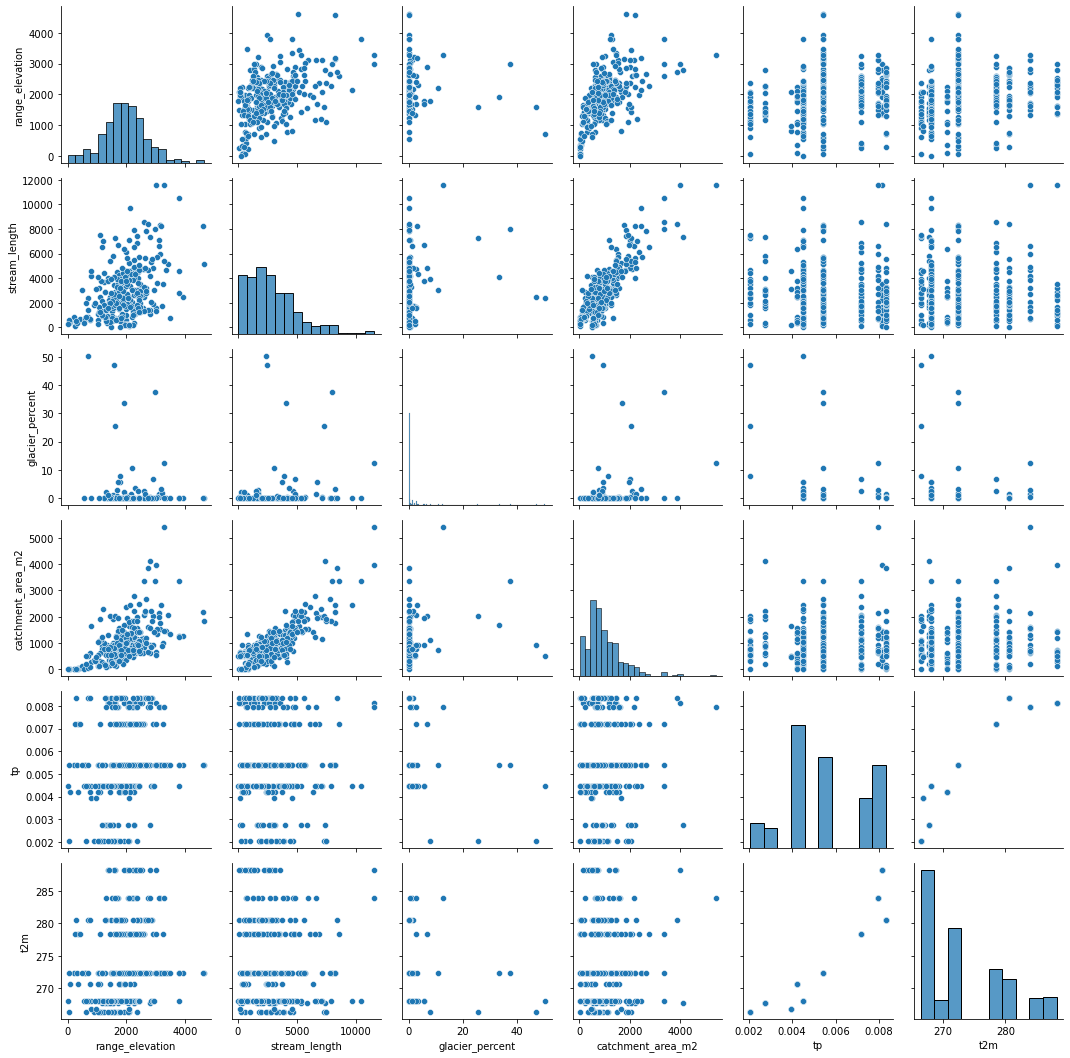

In [55]:
g = sns.PairGrid(params)

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

# plt.savefig('params_scatter.png', dpi = 300, bbox_inches = 'tight')

## Means by month

### 1. means by month (monthly means over time)

In [56]:
# f - original era5 dataset

fmonth = f.groupby('time.month').mean(dim = 'time')

/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/xarray/plot/plot.py:1409: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


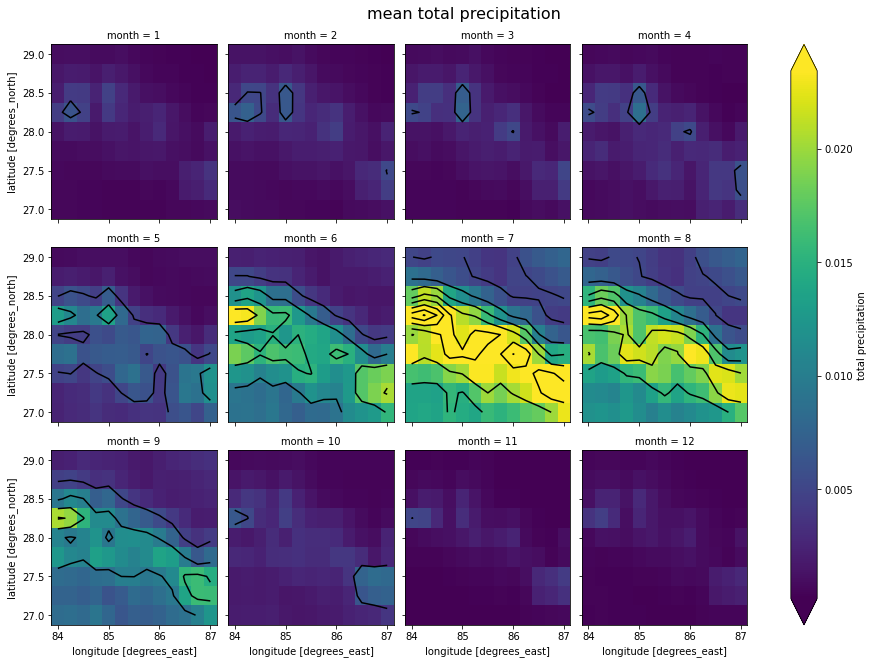

In [57]:
# tutorial: https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html

fig = fmonth.tp.plot.pcolormesh(
    # "longitude",
    # "latitude",
    col="month",
    col_wrap=4,
    robust=True,
    cbar_kwargs={"label": "total precipitation"})

plt.suptitle('mean total precipitation', fontsize=16, y=1.02)



''' add lines if you want to: '''

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fig.map_dataarray(
    xr.plot.contour, x="longitude", y="latitude", colors="k", levels=10, add_colorbar=False)

# Add a point (or anything else!)
# fg.map(lambda: plt.plot(250, 40, markersize=20, marker=".", color="w"))

### get coordinates for monthly mean vallues 

In [58]:
# select points for each parameter: 

# 1. get coordinates:
'''(NB: be carefil with x and y)''' 

catchments = catchments.sort_values(by=['x_wgs', 'y_wgs'])

lats = catchments.y_wgs
lons = catchments.x_wgs

mean_points_monthly = fmonth.sel(longitude=lons, latitude=lats, method='nearest')

# 1.1. add old coordinates - ovewrite dimentions 
mean_points_monthly['longitude'] = lons.values
mean_points_monthly['latitude']= lats.values


In [59]:
mean_points_monthly

<xarray.Dataset>
Dimensions:    (longitude: 297, latitude: 297, month: 12)
Coordinates:
  * longitude  (longitude) float64 85.23 85.24 85.24 85.25 ... 85.88 85.88 85.88
  * latitude   (latitude) float64 28.09 28.12 28.26 28.09 ... 28.16 28.28 28.23
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m        (month, latitude, longitude) float32 280.6 280.6 ... 260.0 260.0
    fal        (month, latitude, longitude) float32 0.1625 0.1625 ... 0.7449
    sd         (month, latitude, longitude) float32 0.01093 0.01093 ... 0.08625
    slhf       (month, latitude, longitude) float32 -3.059e+06 ... -1.935e+05
    tp         (month, latitude, longitude) float32 0.001904 ... 0.001406

In [60]:
np.unique(mean_points_monthly.longitude.values).shape

(240,)

In [61]:
mean_points_monthly_df = mean_points_monthly.to_dataframe()
mean_points_monthly_df
mean_points_monthly_df.columns

Index(['t2m', 'fal', 'sd', 'slhf', 'tp'], dtype='object')

In [62]:
mean_points_monthly_df

t2m       fal        sd          slhf  \
longitude latitude month                                                 
85.235    28.093   1      280.569458  0.162493  0.010932 -3.058500e+06   
                   2      282.438751  0.169537  0.024810 -4.012125e+06   
                   3      285.688324  0.166251  0.028393 -5.452529e+06   
                   4      288.934479  0.149517  0.007083 -6.688130e+06   
                   5      291.407043  0.137159  0.000004 -7.718880e+06   
...                              ...       ...       ...           ...   
85.878    28.225   8      276.712494  0.399902  0.008171 -3.738227e+06   
                   9      274.539429  0.439551  0.008703 -3.454193e+06   
                   10     267.887238  0.588792  0.021481 -1.879928e+06   
                   11     262.812256  0.731583  0.052898 -4.396548e+05   
                   12     260.033386  0.744880  0.086252 -1.935147e+05   

                                tp  
longitude latitude month            
85.235    28.093   1      0.001904  
                   2      0.002600  
                   3      0.002122  
                   4      0.002719  
                   5      0.006691  
...                            ...  
85.878    28.225   8      0.008565  
                   9      0.005438  
                   10     0.002096  
                   11     0.001136  
                   12     0.001406  

[1058508 rows x 5 columns]

In [63]:
# pivot table so that columns correspond to months: 

mean_points_monthly_df_t2m = mean_points_monthly_df.pivot_table(index=['longitude', 'latitude'], 
                                                                 columns='month', values='t2m')

# rename columns
mean_points_monthly_df_t2m.columns = ['t2m_1','t2m_2','t2m_3','t2m_4','t2m_5','t2m_6','t2m_7',
                                        't2m_8','t2m_9','t2m_10','t2m_11','t2m_12']

# mean_points_monthly_df_fal = mean_points_monthly_df.pivot_table(index=['longitude', 'latitude'], 
                                                                # columns='month', values='fal')

# mean_points_monthly_df_sd = mean_points_monthly_df.pivot_table(index=['longitude', 'latitude'], 
                                                                # columns='month', values='sd')

# mean_points_monthly_df_slhf = mean_points_monthly_df.pivot_table(index=['longitude', 'latitude'], 
                                                                # columns='month', values='slhf')

mean_points_monthly_df_tp = mean_points_monthly_df.pivot_table(index=['longitude', 'latitude'], 
                                                                columns='month', values='tp')

mean_points_monthly_df_tp.columns = ['tp_1','tp_2','tp_3','tp_4','tp_5','tp_6','tp_7','tp_8',
                                     'tp_9','tp_10','tp_11','tp_12']


In [64]:
mean_points_monthly_df_t2m.head()

t2m_1       t2m_2       t2m_3       t2m_4  \
longitude latitude                                                   
85.235    28.093    280.569458  282.438751  285.688324  288.934479   
          28.116    280.569458  282.438751  285.688324  288.934479   
          28.259    269.234497  270.838104  273.857086  277.412933   
          28.089    280.569458  282.438751  285.688324  288.934479   
          28.298    269.234497  270.838104  273.857086  277.412933   

                         t2m_5       t2m_6       t2m_7       t2m_8  \
longitude latitude                                                   
85.235    28.093    291.407043  293.462250  293.759399  293.706146   
          28.116    291.407043  293.462250  293.759399  293.706146   
          28.259    281.508423  284.956146  286.316895  286.055450   
          28.089    291.407043  293.462250  293.759399  293.706146   
          28.298    281.508423  284.956146  286.316895  286.055450   

                         t2m_9      t2m_10     t2m_11      t2m_12  
longitude latitude                                                 
85.235    28.093    292.576080  289.061920  285.20462  282.098083  
          28.116    292.576080  289.061920  285.20462  282.098083  
          28.259    284.347351  279.690582  275.24057  271.683167  
          28.089    292.576080  289.061920  285.20462  282.098083  
          28.298    284.347351  279.690582  275.24057  271.683167

In [65]:
# reset index - make latitude and longitude new columns 
# rename columns 
mean_points_monthly_df_tp = mean_points_monthly_df_tp.reset_index()
mean_points_monthly_df_tp_renamed = mean_points_monthly_df_tp.rename(columns = {'longitude': 'x_wgs', 'latitude': 'y_wgs'}) 


In [66]:
# reset index - make latitude and longitude new columns 
# rename columns 
mean_points_monthly_df_t2m = mean_points_monthly_df_t2m.reset_index()
mean_points_monthly_df_t2m_renamed = mean_points_monthly_df_t2m.rename(columns = {'longitude': 'x_wgs', 'latitude': 'y_wgs'}) 



In [68]:
# add to catchments dataset (merge) 

#  merge tables: take 'smaller' table and add the 'bigger' table to it 
# (otherwise there will be a lot of nan vallues, .dropna - if there are any)

catchments_climate1 = catchments_climate.merge(mean_points_monthly_df_tp_renamed, on=['x_wgs', 'y_wgs'], how='left').drop_duplicates()
catchments_climate1 = catchments_climate1.merge(mean_points_monthly_df_t2m_renamed, on=['x_wgs', 'y_wgs'], how='left').drop_duplicates()


### Monsoon precipitation (just sum the columns) 

In [70]:
# mansoon - may - october 
catchments_climate1_mansoon = catchments_climate1

catchments_climate1_mansoon['mansoon_tp'] = catchments_climate1.tp_5 + catchments_climate1.tp_6 + catchments_climate1.tp_7 + catchments_climate1.tp_8 + catchments_climate1.tp_9

In [71]:
catchments_climate1_mansoon['location'] = 'langtang'

In [74]:
# catchments_climate1_mansoon.to_csv('langtang_and_ladakh/langtang_catchments.csv')

## 2. seasonal avarages 

In [ ]:
# tutorial: 
# https://xarray.pydata.org/en/v0.14.1/examples/monthly-means.html

In [ ]:
# only used for comparisons
fseasons = f.groupby('time.season').mean('time')
fseasons

#### 3. monsoon times: may - october

In [ ]:
# same idea as seasonal averages: 

